<a href="https://colab.research.google.com/github/callmesora/Tensorflow-Binary-Classifier-Boilerplate/blob/main/Classifier_BoilerPlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial packages

In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 16s (26.8 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+

In [59]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import files
import numpy as np
from PIL import Image
import time

## Upload Files (If on collab)
Upload the zip files with the photos of the correctly fabricated cables and the photos of the anomaly cables (without the label)

In this notebook mock images will be uploaded from google drive while an Azure data storage is not established

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

## Download form Google Drive (Temporary measurement)


In [4]:
!gdown 1luEMMaODg1cPYgoMasvEJ4csmacJzDmi

Downloading...
From: https://drive.google.com/uc?id=1luEMMaODg1cPYgoMasvEJ4csmacJzDmi
To: /content/anomaly.zip
100% 114M/114M [00:01<00:00, 94.7MB/s]


In [5]:
!gdown 1XdZ_D8z42dnjXNw3xvaewP9vvyJeT-65

Downloading...
From: https://drive.google.com/uc?id=1XdZ_D8z42dnjXNw3xvaewP9vvyJeT-65
To: /content/normal.zip
100% 116M/116M [00:00<00:00, 117MB/s]


# Create File structure
The files should be structed in this way for the script to work:

Two zip files on the main folder (root):


*   normal.zip
*   anomaly.zip

These will then be divided into a data folder /data/ 

This data folder will be further divided into:


*   /data/anomaly/
*   /data/normal





In [7]:
# Create Data folder (Run only once)
!mkdir raw_data

In [8]:
# Clean data folder just in case
# Define root directory
root_dir = './raw_data/'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)


# Extract to zip
anomaly_zip = 'anomaly.zip'
normal_zip = 'normal.zip'

zip_ref = zipfile.ZipFile(anomaly_zip,'r')
zip_ref.extractall(root_dir)
zip_ref.close() 

zip_ref = zipfile.ZipFile(normal_zip,'r')
zip_ref.extractall(root_dir)
zip_ref.close() 

In [9]:
# Rename Folders to class names for better organization
os.rename(os.path.join(root_dir,'Photos'), os.path.join(root_dir,'normal'))
os.rename(os.path.join(root_dir,'Photos2'), os.path.join(root_dir,'anomaly'))

In [10]:
source_path_normal = os.path.join(root_dir, 'normal')
source_path_anomaly = os.path.join(root_dir, 'anomaly')

# Deletes all non-image files (If there are corrupedted files)
!find ./data/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_normal))} normal images.")
print(f"There are {len(os.listdir(source_path_anomaly))} anomaly images")

find: ‘./data/’: No such file or directory
There are 100 normal images.
There are 100 anomaly images


Expected Output:


*   There are **x** anomaly images.
*   There are **y** normal images.



## Splitting into train/val
You will need a directory for data, and subdirectories for training and validation. These in turn will need subdirectories for 'anomaly' and 'normal'



In [11]:
# Define root directory
source_dir = './data/'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(source_dir):
  shutil.rmtree(source_dir)

def create_train_val_dirs(source_dir):
  """
  Creates directories for the train and test sets
  
  Args:
    source_dir (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """  

  # Create train,val paths
  train_path = os.path.join(source_dir,'training')
  val_path = os.path.join(source_dir,'validation')
  
  # Create dynamic path for each class
  normal_train = os.path.join(train_path,'normal')
  normal_val = os.path.join(val_path,'normal')
  
  anomaly_train = os.path.join(train_path,'anomaly')
  anomaly_val = os.path.join(val_path,'anomaly')

  # Create directories
  os.makedirs(normal_train)
  os.makedirs(normal_val)

  os.makedirs(anomaly_train)
  os.makedirs(anomaly_val)

  return 

  
try:
  create_train_val_dirs(source_dir=source_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [12]:
# Test  create_train_val_dirs function

for rootdir, dirs, files in os.walk(source_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./data/validation
./data/training
./data/validation/anomaly
./data/validation/normal
./data/training/anomaly
./data/training/normal


Split Function:



```
os.listdir(DIRECTORY) returns a list with the contents of that directory.

os.path.getsize(PATH) returns the size of the file

copyfile(source, destination) copies a file from source to destination

random.sample(list, len(list)) shuffles a list
```



In [13]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  """
  Cleans corrupted files then splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """
  
  ## Clean the Data (Sometimes there are currupted images with zero lenght)
  imgs = os.listdir(SOURCE_DIR)
  clean_imgs = list()
  corrupt_imgs = list() 
  for file in imgs: 
    if os.path.getsize(os.path.join(SOURCE_DIR,file)) > 0:
      clean_imgs.append(file)

    else:
      corrupt_imgs.append(file)
      print('filename is zero lenght, so ignoring')
  
    

    


  ## Split the images
  SPLIT_IDX = int(SPLIT_SIZE*len(clean_imgs)) # To round the index
  clean_imgs = random.sample(clean_imgs,len(clean_imgs)) #shuffle dir
  train_imgs = clean_imgs[:SPLIT_IDX]
  val_imgs = clean_imgs[SPLIT_IDX:]

  #shuffle lists
  

  # Copy files from source dir to train /val dirs (using map to avoid loop)

  for file in train_imgs:
    copyfile(os.path.join(SOURCE_DIR,file),os.path.join(TRAINING_DIR,file))

  for file in val_imgs:
    copyfile(os.path.join(SOURCE_DIR,file), os.path.join(VALIDATION_DIR,file))

  #train_imgs = map(lambda x: copyfile(os.path.join(SOURCE_DIR,x),os.path.join(TRAINING_DIR,x)),train_imgs)
  #val_imgs= map(lambda x: copyfile(os.path.join(SOURCE_DIR,x),os.path.join(VALIDATION_DIR,x)), val_imgs)




In [14]:
# Test  split_data function

# Define paths
NORMAL_SOURCE_DIR = "./raw_data/normal/"
ANOMALY_SOURCE_DIR = "./raw_data/anomaly/"

TRAINING_DIR = "./data/training/"
VALIDATION_DIR = "./data/validation/"

TRAINING_NORMAL_DIR = os.path.join(TRAINING_DIR, "normal/")
VALIDATION_NORMAL_DIR = os.path.join(VALIDATION_DIR, "normal/")

TRAINING_ANOMALY_DIR = os.path.join(TRAINING_DIR, "anomaly/")
VALIDATION_ANOMALY_DIR = os.path.join(VALIDATION_DIR, "anomaly/")

## Empty directories in case you run this cell multiple times
# Clean Training Dir 
if len(os.listdir(TRAINING_NORMAL_DIR)) > 0:
  for file in os.scandir(TRAINING_NORMAL_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_ANOMALY_DIR)) > 0:
  for file in os.scandir(TRAINING_ANOMALY_DIR):
    os.remove(file.path)
# Clean Validation dir
if len(os.listdir(VALIDATION_NORMAL_DIR)) > 0:
  for file in os.scandir(VALIDATION_NORMAL_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_ANOMALY_DIR)) > 0:
  for file in os.scandir(VALIDATION_ANOMALY_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, VALIDATION_NORMAL_DIR, split_size)
split_data(ANOMALY_SOURCE_DIR, TRAINING_ANOMALY_DIR, VALIDATION_ANOMALY_DIR, split_size)


# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_NORMAL_DIR))} images of normal for training")
print(f"There are {len(os.listdir(TRAINING_ANOMALY_DIR))} images of anomaly for training")
print(f"There are {len(os.listdir(VALIDATION_ANOMALY_DIR))} images of normal for validation")# Check that the number of images matches the expected output

# Check if function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal normal's directory has {len(os.listdir(NORMAL_SOURCE_DIR))} images")
print(f"Original anomaly's directory has {len(os.listdir(ANOMALY_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_NORMAL_DIR))} images of normal for training")
print(f"There are {len(os.listdir(TRAINING_ANOMALY_DIR))} images of anomaly for training")
print(f"There are {len(os.listdir(VALIDATION_NORMAL_DIR))} images of normal for validation")
print(f"There are {len(os.listdir(VALIDATION_ANOMALY_DIR))} images of anomaly for validation")



There are 80 images of normal for training
There are 80 images of anomaly for training
There are 20 images of normal for validation


Original normal's directory has 100 images
Original anomaly's directory has 100 images

There are 80 images of normal for training
There are 80 images of anomaly for training
There are 20 images of normal for validation
There are 20 images of anomaly for validation


Sample Normal image:


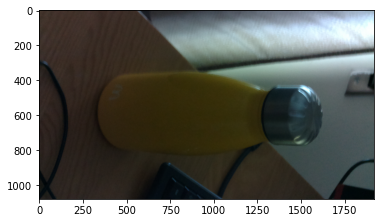


Sample Normal image:


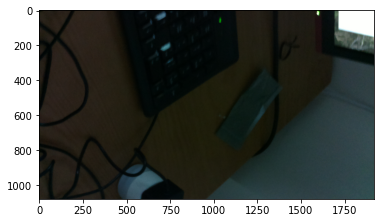

In [15]:
# Plot Sample Images
print("Sample Normal image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_NORMAL_DIR, os.listdir(TRAINING_NORMAL_DIR)[random.randint(0,50)])}"))
plt.show()

print("\nSample Normal image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_ANOMALY_DIR, os.listdir(TRAINING_ANOMALY_DIR)[random.randint(0,50)])}"))
plt.show()

The data is now in format ready for Keras 'ImageDataGenerator' 
So now generators will be created

Note: This function will also resize the resolution of the images, in the raspberry we collected images from the same camera so it wouldnt be an issue but the code will be dynamically typed for further use

In [16]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMG_SIZE):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.2,
                                     width_shift_range=0.1,
                                     height_shift_range=0.15,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Re-sizing to (150,150) change afterwords deppending on the model 
  # or depending on raspberry inference speed
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=IMG_SIZE)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Create Generator
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=IMG_SIZE)
  return train_generator, validation_generator

In [17]:
# Test your generators
IMG_SIZE = (160,160)
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMG_SIZE)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [18]:
IMG_SIZE + (3,)

(160, 160, 3)

Expected Output:

Found x-train images belonging to 2 classes.

Found y-val images belonging to 2 classes.

# Define the model architecture and Train the Model (Normal CNN)

In [19]:
def create_model():

  #MODEL ARCHITECTURE (FIRST VERSION)
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(160,160,3)),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128),
      tf.keras.layers.Dense(1,activation='sigmoid')
  ])

  #TODO: ADD CALLBACKS TO SAVE MODEL AND PERFORM CHECKPOINTS
 

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

In [20]:
# Get the untrained model
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 41472)             0

In [24]:
# Train the model
# Note that this may take some time.

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)]
  

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model-epoch-{epoch:03d}.h5', verbose=1,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',save_best_only=True)

# If you want to save the model turn on checkpoints
#callbacks.append(model_checkpoint_callback)

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,callbacks=callbacks)

Epoch 1/15
5/5 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.5625
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to model-weight-001.h5
5/5 [==============================] - 23s 5s/step - loss: 0.6585 - accuracy: 0.5625 - val_loss: 0.4899 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/15
5/5 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8313
Epoch 2: val_accuracy improved from 0.85000 to 0.87500, saving model to model-weight-002.h5
5/5 [==============================] - 20s 4s/step - loss: 0.4263 - accuracy: 0.8313 - val_loss: 0.3069 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/15
5/5 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8313
Epoch 3: val_accuracy improved from 0.87500 to 0.92500, saving model to model-weight-003.h5
5/5 [==============================] - 21s 4s/step - loss: 0.3119 - accuracy: 0.8313 - val_loss: 0.1920 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/15
5/5 [===============

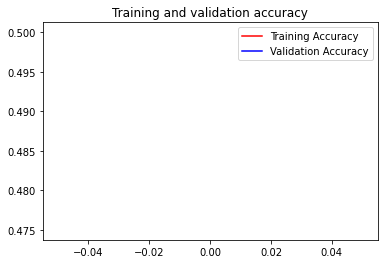

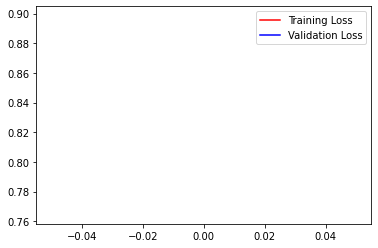

In [22]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label= "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc=0)
plt.show()

## Save the Model and convert to TF Lite



In [29]:
#Note this simple deployment will probably only work with models created using keras Sequential API.
# It hasn't been tested with other models
model_name = 'test_model_01'
save_model = False

if save_model == True:
  model.save(model_name+'.h5')


In [47]:
# Generate a .tf_lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(model_name + '.tflite','wb').write(tflite_model) 

21355568

Download File from colab

In [50]:
# Set up a variable just so the notebook could run without stoppage
Download_TF_Lite_Model = True # Change to true to download the model
if Download_TF_Lite_Model == True:
  files.download(model_name + '.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run Inference using Tf Lite

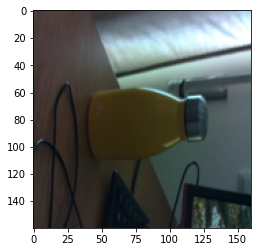

In [126]:
# Here I will load images as pillow files, later this can be upgraded to a np array directly from cv2 for faster inference

# Load an image to be classified.
image = Image.open('./raw_data/normal/' + "test0.jpg").convert('RGB').resize((width, height))
plt.imshow(image)  # Resized Image

In [127]:
interpreter = tf.lite.Interpreter(model_path= model_name + '.tflite')
interpreter.allocate_tensors()

#Get image shape from model 
_, height, width, _ = interpreter.get_input_details()[0]['shape']
print("Image Shape (", width, ",", height, ")")


# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

Image Shape ( 160 , 160 )


In [129]:
# Conver to np array
I = np.asarray(image, dtype=np.float32) # Convert Pillow Image to np array 

#Expand dim to match a batch_size of one
I_expanded = np.expand_dims(I, axis=0)

interpreter.set_tensor(input_details[0]['index'], I_expanded) # Send Tensor to model

interpreter.invoke() # Invoke interperter
output_data = interpreter.get_tensor(output_details[0]['index']) # Get output

def predict_on_treshold(output_data,threshold):
  value = output_data[0][0]

  percent = value *100
  if value > threshold:
    print(f'Model Prediction: Normal with confidence score of {percent:.2f}%')
  else:
    print(f'Model Prediction: Anomaly with confidence score of {(100-percent):.2f}%')



# Define threshold ( I will set conf_treshold = 50%)
threshold = 0.5
predict_on_treshold(output_data,threshold)

Model Prediction: Normal with confidence score of 100.00%


# Transfer Learning Aproach
If the normal model is not enough further attempts will be made with transfer learning. Here are some helper functioins with some SOTA detectors

## Tests with MobileNetV2


In [ ]:
# Create Base model . Check input shape on data loader
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Test Image shape
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Expected output:
(batch_size,5,5,1280 features)

In [ ]:
# Freeze Layers
base_model.trainable = False #option one

## Classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations from MobileNet (this may change with other models), using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.Sequential([
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 sequential_6 (Sequential)   (None, 1)                 82049     
                                                                 
Total params: 2,340,033
Trainable params: 82,049
Non-trainabl

In [ ]:
# Check initial Accuracy of pre-trained model

loss0, accuracy0 = model.evaluate(validation_generator)

2/2 [==============================] - 3s 115ms/step - loss: 0.8149 - accuracy: 0.4250


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.43


In [ ]:
initial_epochs = 10

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)]
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 0.5660 - accuracy: 0.7250 - val_loss: 0.3835 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 0.5076 - accuracy: 0.7625 - val_loss: 0.3113 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 0.4093 - accuracy: 0.8562 - val_loss: 0.2548 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 0.3652 - accuracy: 0.8813 - val_loss: 0.2086 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 0.3165 - accuracy: 0.9187 - val_loss: 0.1773 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 0.2639 - accuracy: 0.9375 - val_loss: 0.1549 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 7/10
5/5 [==============================] - 9s 2s/step - loss: 0.2447

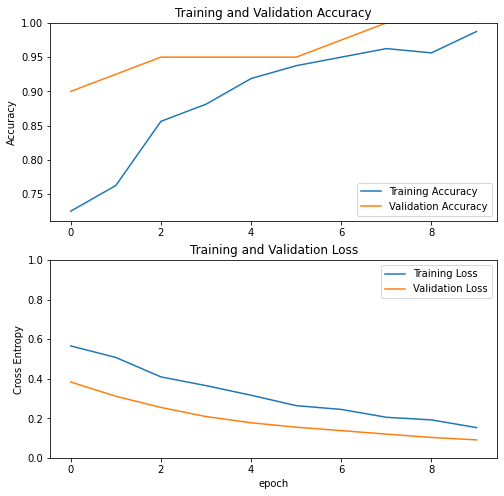

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the pre-trained model
If after the initial epochs we still want some further training we can fine-tune the model by training some of the frozen layers. 

We should be carefull because if the size of the dataset is too small the model might overfit. So only run this cell if deemed necessary



In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#Lowered the learning rate so we don't mess up the pre-trained weights with a big batch update
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()


Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 sequential_6 (Sequential)   (None, 1)                 82049     
                                                                 
Total params: 2,340,

In [ ]:
len(model.trainable_variables)


58

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

#Starting from where we left off previously we set the initial epoch to the last
history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 10/20
5/5 [==============================] - 15s 2s/step - loss: 0.1351 - accuracy: 0.9438 - val_loss: 0.0330 - val_accuracy: 1.0000
Epoch 11/20
5/5 [==============================] - 10s 2s/step - loss: 0.0651 - accuracy: 0.9812 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 12/20
5/5 [==============================] - 10s 2s/step - loss: 0.0403 - accuracy: 0.9937 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 13/20
5/5 [==============================] - 10s 2s/step - loss: 0.0388 - accuracy: 0.9812 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 14/20
5/5 [==============================] - 10s 2s/step - loss: 0.0463 - accuracy: 0.9937 - val_loss: 0.0166 - val_accuracy: 1.0000
Epoch 15/20
5/5 [==============================] - 10s 2s/step - loss: 0.0297 - accuracy: 0.9937 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 16/20
5/5 [==============================] - 10s 2s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 17/20
5/5 [==========

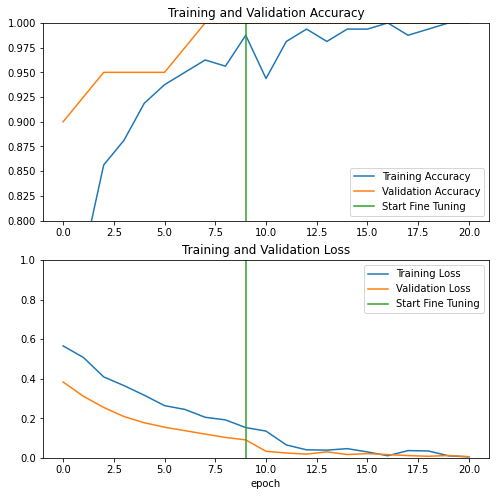

In [ ]:
# Plot the differences after the fine tunning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Transfer Learning using TensorFlow Hub
This is an alternative (less flexibility but easier to set up version) for the code above




In [ ]:
import tensorflow_hub as hub

import datetime


mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 # Select Mobile net from the Hub

# Create feature extraction Layer 
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

# The feature extractor from the hub only works with 224,224 images
# So we need to add a resizing layer 
# This is an experimental function from TF2

model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(224,224),

  feature_extractor_layer,
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(1,activation='sigmoid')
])

model.build(input_shape=(None,150,150,3))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer_13 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dense_39 (Dense)            (None, 64)                81984     
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,340,033
Trainable params: 82,049
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='binary_crossentropy',
  metrics=['acc'])

In [ ]:
NUM_EPOCHS = 10

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=NUM_EPOCHS)

Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 0.5342 - acc: 0.7250 - val_loss: 0.0492 - val_acc: 1.0000
Epoch 2/10
5/5 [==============================] - 11s 2s/step - loss: 0.0632 - acc: 0.9750 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 3/10
5/5 [==============================] - 11s 2s/step - loss: 0.0352 - acc: 0.9875 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 4/10
5/5 [==============================] - 11s 2s/step - loss: 0.0285 - acc: 0.9875 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 5/10
5/5 [==============================] - 11s 2s/step - loss: 0.0260 - acc: 0.9875 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 6/10
5/5 [==============================] - 10s 2s/step - loss: 0.0051 - acc: 1.0000 - val_loss: 7.2374e-04 - val_acc: 1.0000
Epoch 7/10
5/5 [==============================] - 10s 2s/step - loss: 0.0143 - acc: 0.9937 - val_loss: 6.3774e-04 - val_acc: 1.0000
Epoch 8/10
5/5 [==============================] - 10s 2s/step - loss: 0.0283 - acc: 0.9937 - val

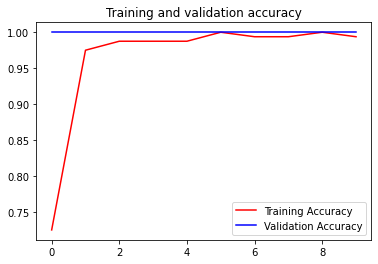

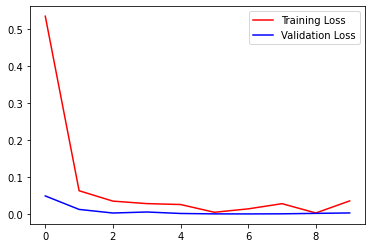

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label= "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label= "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend(loc=0)
plt.show()

# Save Model plot data with history Pickles

It is important to save model logs, so this helper function was created to save history plots in the form of a pickle



In [42]:
def download_history(history):
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history(history)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
def load_history(history_file):
  import pickle
  from google.colab import files 
  
  with open(history_file, 'rb') as handle:
    loaded_history = pickle.load(handle)

  return loaded_history

In [40]:
def plot_from_pickle(hitory_pickle):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'r', label="Training Accuracy")
  plt.plot(epochs, val_acc, 'b', label= "Validation Accuracy")
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.show()
  print("")

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'r', label= "Training Loss")
  plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
  plt.legend(loc=0)
  plt.show()

In [41]:
loaded_history = load_history('history_augmented.pkl')
plot_from_pickle(loaded_history)

FileNotFoundError: ignored